#Sequencing Success: A Hands-On Workshop in Deep Learning for Sequence-to-Sequence Models
Moratuwa Engineering Research Conference 2023 (MERCon 2023) is the 9th international conference organized by the Engineering Research Unit at the University of Moratuwa. As part of MERCon 2023, we are hosting a Hands-On Workshop on Deep Learning for Sequence-to-Sequence Models. This workshop spans four hours and is divided into four one-hour sessions, covering the following topics:
- Introduction to Sequence-to-Sequence Learning
- Sequence-to-Sequence Learning with Recurrent Neural Networks (RNNs)
- Sequence-to-Sequence Learning with Encoder-Decoder Models
- Sequence-to-Sequence Learning with Encoder-Decoder Models and Attention Mechanisms

This notebook is prepared for session **Sequence-to-Sequence Learning with Recurrent Neural Networks**.

All rights reserved.

Authors:
1.   Dr.T.Uthayasanker ([rtuthaya.lk](https://rtuthaya.lk))
2.   Mr.S.Braveenan ([Braveenan Sritharan](https://www.linkedin.com/in/braveenan-sritharan/))

[For more information - MERCon 2023](https://mercon.uom.lk)

#A Simple Seq2Seq Problem 2: The reverse sentence problem
In this simple Seq2Seq problem, we are provided with a **parallel dataset** comprising two sentences, X (input) and y (output). In this scenario, the output sentence, y[i], is constructed by reversing the order of the words in the input sentence, X[i]. To illustrate, consider an example where the **input sentence X[i]** has a length of 6, such as:

X[i] = **he ate apple**

The corresponding **output sentence, y[i]**, would be:

y[i] = **apple ate he**

This problem serves as a foundational example of a Sequence-to-Sequence (Seq2Seq) task, where the objective is to learn to reverse sentences effectively.

In [1]:
#@title Import Libraries
import random
import numpy as np
import matplotlib.pyplot as plt

from keras import Input
from keras.layers import RepeatVector, Dense, SimpleRNN, GRU, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential, Model

#Auxiliary functions

Certainly! Here's a more concise introduction to the key functions in the code snippet:
1. **generate_text_sequence(length, word_array)**: Generates a random text sequence of a given length using words from an array.
2. **one_hot_encode_text(text_sequence, word_array)**: Converts a text sequence into one-hot encoded vectors using a word array.
3. **one_hot_decode_text(encoded_seq, word_array)**: Decodes a one-hot encoded sequence back into its original text form.
4. **get_reversed_pairs(time_steps, word_array, verbose=False)**: Generates pairs of random sequences and their reversals, one-hot encodes them, and returns them for training.
5. **create_dataset(train_size, test_size, time_steps, word_array, verbose=False)**: Creates training and testing datasets by generating reversed pairs.
6. **train_test(model, X_train, y_train, X_test, y_test, epochs=100, verbose=0)**: Trains a neural network model, evaluates it, and returns the model and training history.
7. **visualize_history(history)**: Visualizes the training history, showing accuracy and loss over epochs.
8. **check_samples(model, X_test, y_test, word_array, num_samples=10)**: Checks the model's performance on a set of sample sequences from the testing data.

These functions collectively support the process of training and evaluating a neural network for a sentence reversal task.

In [2]:
#@title Function to generate a text sequence
# generate sequence
def generate_text_sequence(length, word_array):
    word_sequence = [random.choice(word_array) for _ in range(length)]
    text_sequence = ' '.join(word_sequence)
    return text_sequence

In [3]:
#@title Function to encode and decode text sequence
# one hot encode sequence
def one_hot_encode_text(text_sequence, word_array):
    encoding = []
    for word in text_sequence.split():
        vector = [0] * len(word_array)
        if word in word_array:
            vector[word_array.index(word)] = 1
        encoding.append(vector)
    return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode_text(encoded_seq, word_array):
    decoded_sequence = [word_array[np.argmax(vector)] for vector in encoded_seq]
    return ' '.join(decoded_sequence)

In [4]:
#@title Function to generate reverse pair dataset
# create one reverse pair
def get_reversed_pairs(time_steps,word_array,verbose= False):
		# generate random sequence
		sequence_in = generate_text_sequence(time_steps, word_array)
		sequence_out = ' '.join(sequence_in.split()[::-1])

		# one hot encode
		X = one_hot_encode_text(sequence_in, word_array)
		y = one_hot_encode_text(sequence_out, word_array)
		# reshape as 3D
		X = X.reshape((1, X.shape[0], X.shape[1]))
		y = y.reshape((1, y.shape[0], y.shape[1]))

		if(verbose):
			print('\nSample X and y')
			print('\nIn raw format:')
			print('X[0]=%s, y[0]=%s' % (one_hot_decode_text(X[0], word_array), one_hot_decode_text(y[0], word_array)))
			print('\nIn one_hot_encoded format:')
			print('X[0]=%s' % (X[0]))
			print('y[0]=%s' % (y[0]))
		return X,y

# create final dataset
def create_dataset(train_size, test_size, time_steps,word_array, verbose= False):
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(train_size)]
		pairs=np.array(pairs).squeeze()
		X_train = pairs[:,0]
		y_train = pairs[:,1]
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(test_size)]
		pairs=np.array(pairs).squeeze()
		X_test = pairs[:,0]
		y_test = pairs[:,1]

		if(verbose):
			print('\nGenerated sequence datasets as follows')
			print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
			print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

		return X_train, y_train, X_test, 	y_test

In [5]:
#@title Function to train and evaluate model
def train_test(model, X_train, y_train , X_test, y_test, epochs=100, verbose=0):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # train model
    print('training for ',epochs,' epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....')
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    return model, history.history

In [6]:
#@title Function to visualize loss and accuracy
def visualize_history(history):
	# summarize history for accuracy
	plt.plot(history['accuracy'])
	plt.plot(history['val_accuracy'])
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history['loss'])
	plt.plot(history['val_loss'])
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

In [7]:
#@title Function to check some examples
def check_samples(model, X_test, y_test, word_array, num_samples=10):
    sample_indices = random.sample(range(len(X_test)), num_samples)

    for id in sample_indices:
        X, y = X_test[id], y_test[id]
        X = np.expand_dims(X, axis=0)
        y = np.expand_dims(y, axis=0)
        yhat = model.predict(X, verbose=0)
        print(f"Input: {one_hot_decode_text(X[0], word_array)} \nExpected: {one_hot_decode_text(y[0], word_array)} \nPredicted: {one_hot_decode_text(yhat[0], word_array)} \n{np.array_equal(one_hot_decode_text(y[0], word_array), one_hot_decode_text(yhat[0], word_array))}\n")

#Create reverse sentence dataset


This code snippet is designed to generate a dataset for the **Reverse Sentence Task**. In this task, each data point consists of a sentence and its reversed counterpart. The essential parameters include the input sequence length (n_timesteps_in), the number of unique words (n_features), the size of the training dataset (train_size), and the size of the testing dataset (test_size).

The code accomplishes the following:
1. It generates a random sentence and its reversed version, one-hot encodes them, and optionally displays sample pairs of sentences to illustrate the dataset structure.
2. The code then creates training and testing datasets by generating pairs of random sentences and their reversals. The dataset sizes are determined by the parameters train_size and test_size.

This dataset is a crucial component for training and evaluating models for the **Reverse Sentence Task**, which is a common problem in natural language processing.

In [8]:
word_array = ["apple", "banana", "cherry", "orange", "strawberry",
             "carrot", "broccoli", "potato", "tomato", "cucumber",
             "rose", "tulip", "daisy", "lily", "sunflower",
             "red", "blue", "green", "yellow", "purple",
             "Colombo", "London", "Paris", "Tokyo", "Sydney",
             "car", "bus", "bicycle", "train", "motorcycle",
             "guitar", "piano", "violin", "trumpet", "flute",
             "beach", "mountain", "park", "desert", "island",
             "book", "computer", "chair", "table", "lamp",
             "dog", "cat", "bird", "elephant", "lion"]

In [9]:
#@title Generating dataset
# Default configuration parameters
n_timesteps_in = 18
n_features = len(word_array)
train_size = 20000
test_size = 200

# Generate random sequence using specified parameters
X, y = get_reversed_pairs(n_timesteps_in, word_array, verbose=True)

# Generate datasets using specified parameters
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in, word_array, verbose=True)


Sample X and y

In raw format:
X[0]=elephant train broccoli daisy lamp yellow car guitar table Colombo guitar tulip broccoli Paris apple green bus beach, y[0]=beach bus green apple Paris broccoli tulip guitar Colombo table guitar car yellow lamp daisy broccoli train elephant

In one_hot_encoded format:
X[0]=[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 

#1. Multi-Layer Perceptron network model

In your initial solution to the reverse sequence problem, a Multi-Layer Perceptron (MLP) network model has been employed, consisting of input, hidden, and output layers. The model is trained with categorical cross-entropy loss and optimized using Adam. It is evaluated on the datasets you created, and its training history is visualized. This MLP approach serves as an introductory solution for addressing the reverse sequence problem, using the datasets you generated, and provides insights into how well a simple feedforward neural network can perform on this task.

In [10]:
#@title Create Multi-Layer Perceptron network model
numberOfPerceptrons=16
model_Multi_Layer_Perceptron = Sequential(name='model_Multi_Layer_Perceptron')
model_Multi_Layer_Perceptron.add(Input(shape=(n_timesteps_in, n_features)))
model_Multi_Layer_Perceptron.add(Dense(2*numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(n_features, activation='softmax'))

model_Multi_Layer_Perceptron.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Multi_Layer_Perceptron.summary()
plot_model(model_Multi_Layer_Perceptron,show_shapes=True)

Model: "model_Multi_Layer_Perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 18, 32)         │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18, 50)         │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,010 (11.76 KB)

 Trainable params: 3,010 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [11]:
#@title Train and Evaluate Multi-Layer Perceptron network model
trained_model_mlp, history_mlp = train_test(model_Multi_Layer_Perceptron, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 2s - 4ms/step - accuracy: 0.0196 - loss: 3.9147 - val_accuracy: 0.0191 - val_loss: 3.9130
Epoch 2/100
563/563 - 1s - 2ms/step - accuracy: 0.0206 - loss: 3.9122 - val_accuracy: 0.0191 - val_loss: 3.9128
Epoch 3/100
563/563 - 1s - 2ms/step - accuracy: 0.0212 - loss: 3.9117 - val_accuracy: 0.0199 - val_loss: 3.9128
Epoch 4/100
563/563 - 1s - 2ms/step - accuracy: 0.0215 - loss: 3.9115 - val_accuracy: 0.0190 - val_loss: 3.9132
Epoch 5/100
563/563 - 1s - 2ms/step - accuracy: 0.0218 - loss: 3.9113 - val_accuracy: 0.0202 - val_loss: 3.9133
Epoch 6/100
563/563 - 1s - 2ms/step - accuracy: 0.0216 - loss: 3.9112 - val_accuracy: 0.0194 - val_loss: 3.9134
Epoch 7/100
563/563 - 1s - 1ms/step - accuracy: 0.0222 - loss: 3.9110 - val_accuracy: 0.0192 - val_loss: 3.9136
Epoch 8/100
563/563 - 1s - 1ms/step - accuracy: 0.0222 - loss: 3.9109 - val_accuracy: 0.0196 - val_loss:

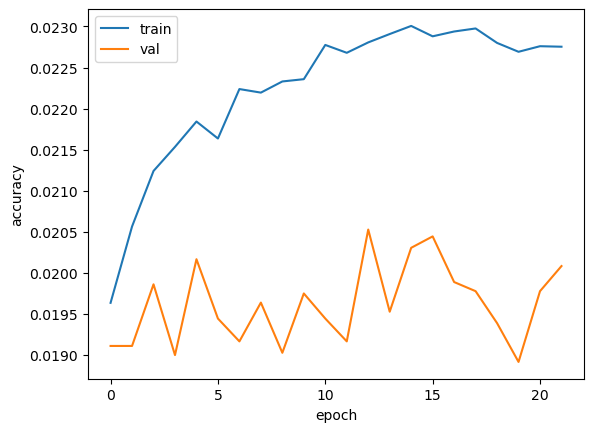

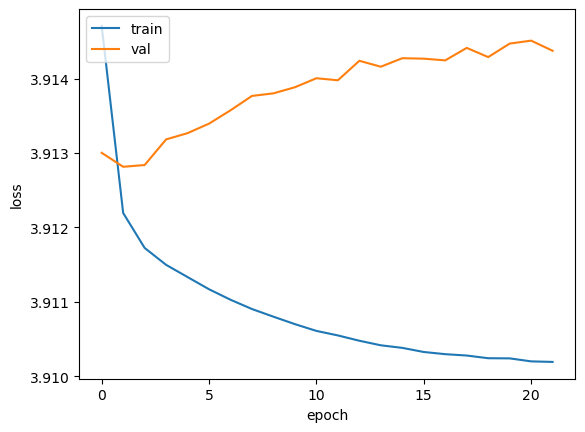

In [12]:
#@title Visualize training and validation Multi-Layer Perceptron network model
visualize_history(history_mlp)

In [13]:
#@title Check random samples Multi-Layer Perceptron network model
check_samples(trained_model_mlp, X_test, y_test, word_array, num_samples=10)

Input: banana flute lily mountain bus book trumpet piano elephant blue lion Paris apple lily beach desert strawberry bicycle 
Expected: bicycle strawberry desert beach lily apple Paris lion blue elephant piano trumpet book bus mountain lily flute banana 
Predicted: flute piano motorcycle carrot red trumpet book flute elephant carrot cucumber Tokyo Tokyo motorcycle bus bus strawberry daisy 
False

Input: apple book motorcycle Tokyo beach lily dog purple strawberry chair train blue Colombo lamp book dog blue island 
Expected: island blue dog book lamp Colombo blue train chair strawberry purple dog lily beach Tokyo motorcycle book apple 
Predicted: Tokyo trumpet flute motorcycle bus motorcycle island apple strawberry yellow violin carrot blue yellow trumpet island carrot dog 
False

Input: cherry Colombo cat park car Tokyo park bird sunflower Sydney Sydney train cat guitar lily purple tomato carrot 
Expected: carrot tomato purple lily guitar cat train Sydney Sydney sunflower bird park Tok

#2. Recurrent Neural Networks

Multi-Layer Perceptrons (MLPs) are great for many tasks, but they don't understand the order of things in a sequence. They treat all data equally. For tasks that involve sequences, like time-related data, we need something smarter. That's where Recurrent Neural Networks (RNNs) come in. RNNs are like the **sequence experts** of neural networks. They know the importance of the order of things. There are different types of RNNs, such as Simple RNNs, Gated Recurrent Units (GRUs), and Long-Short Term Memory (LSTM) networks. These special RNNs are designed to understand and work with sequences, making them perfect for tasks where the order of data matters a lot.

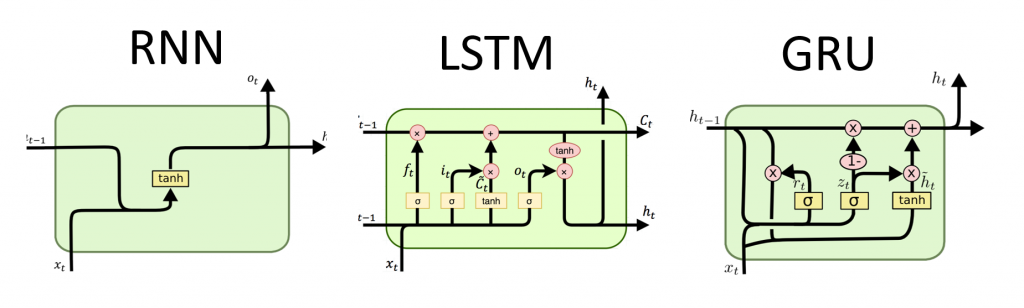

#2.1. Simple Recurrent Neural Network model (RNN)

In this section, we'll be using a Simple Recurrent Neural Network (Simple RNN) to solve the reverse sequence problem. Simple RNNs work a bit like detectives for sequences. They understand the order of things in a sequence because they remember what happened earlier. Simple RNNs keep a hidden memory of past information and use this memory to link input and output in the right order.

In [14]:
#@title Create simple RNN model
numberOfUnits = 16
model_RNN = Sequential(name='model_RNN')
model_RNN.add(Input(shape=(n_timesteps_in, n_features)))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()
plot_model(model_RNN, show_shapes=True)

Model: "model_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 18, 16)         │         1,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 18, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 18, 50)         │           850 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,450 (9.57 KB)

 Trainable params: 2,450 (9.57 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [15]:
#@title Train and Evaluate simple RNN model
trained_model_rnn, history_rnn = train_test(model_RNN, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 5s - 9ms/step - accuracy: 0.0304 - loss: 3.8834 - val_accuracy: 0.0427 - val_loss: 3.8375
Epoch 2/100
563/563 - 2s - 4ms/step - accuracy: 0.0459 - loss: 3.8087 - val_accuracy: 0.0530 - val_loss: 3.7809
Epoch 3/100
563/563 - 2s - 4ms/step - accuracy: 0.0564 - loss: 3.7600 - val_accuracy: 0.0579 - val_loss: 3.7447
Epoch 4/100
563/563 - 3s - 5ms/step - accuracy: 0.0626 - loss: 3.7249 - val_accuracy: 0.0638 - val_loss: 3.7102
Epoch 5/100
563/563 - 4s - 7ms/step - accuracy: 0.0668 - loss: 3.7003 - val_accuracy: 0.0667 - val_loss: 3.6962
Epoch 6/100
563/563 - 3s - 5ms/step - accuracy: 0.0703 - loss: 3.6806 - val_accuracy: 0.0755 - val_loss: 3.6674
Epoch 7/100
563/563 - 3s - 5ms/step - accuracy: 0.0769 - loss: 3.6512 - val_accuracy: 0.0802 - val_loss: 3.6438
Epoch 8/100
563/563 - 3s - 5ms/step - accuracy: 0.0806 - loss: 3.6310 - val_accuracy: 0.0838 - val_loss:

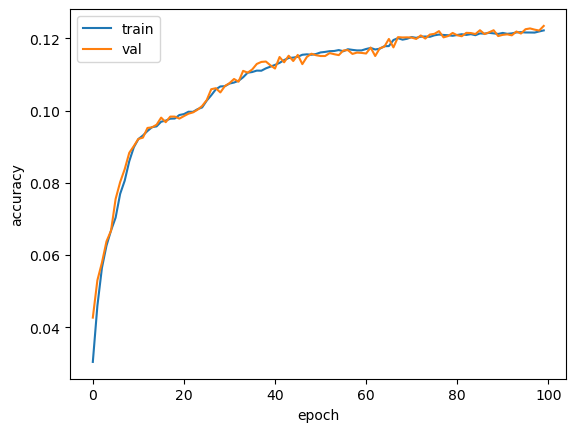

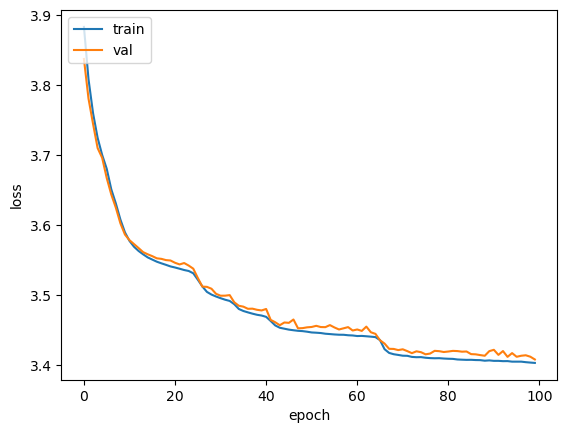

In [16]:
#@title Visualize training and validation simple RNN model
visualize_history(history_rnn)

In [17]:
#@title Check random samples simple RNN model
check_samples(trained_model_rnn, X_test, y_test, word_array, num_samples=10)

Input: trumpet table desert cat bird green trumpet daisy car lily dog desert banana lamp yellow purple table dog 
Expected: dog table purple yellow lamp banana desert dog lily car daisy trumpet green bird cat desert table trumpet 
Predicted: potato trumpet table London table tomato table trumpet table trumpet table trumpet table trumpet table trumpet table trumpet 
False

Input: blue daisy bus book island Colombo computer sunflower cherry cherry motorcycle lamp beach cucumber cat broccoli bird dog 
Expected: dog bird broccoli cat cucumber beach lamp motorcycle cherry cherry sunflower computer Colombo island book bus daisy blue 
Predicted: blue blue daisy blue daisy blue daisy blue daisy blue daisy blue daisy blue daisy blue daisy blue 
False

Input: purple mountain Tokyo Sydney strawberry train Sydney cucumber cat rose potato Colombo elephant guitar green motorcycle computer elephant 
Expected: elephant computer motorcycle green guitar elephant Colombo potato rose cat cucumber Sydney t

#2.2. Gated Recurrent Units model (GRU)

In this section, we will use Gated Recurrent Units (GRUs) to address some of the issues we encountered with Simple RNN. You see, Simple RNNs can forget important details when working with long sequences, which makes them less effective. GRUs feature a more intelligent architecture that helps them remember and utilize information more effectively. They incorporate **gates** that control what they remember and what they forget, making them excellent at understanding both short and long patterns in sequences.

In [18]:
#@title Create GRU model
numberOfUnits = 16
model_GRU = Sequential(name='model_GRU')
model_GRU.add(Input(shape=(n_timesteps_in, n_features)))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()
plot_model(model_GRU, show_shapes=True)

Model: "model_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 18, 16)         │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 18, 16)         │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 18, 50)         │           850 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,746 (22.45 KB)

 Trainable params: 5,746 (22.45 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [19]:
#@title Train and Evaluate GRU model
trained_model_gru, history_gru = train_test(model_GRU, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 9s - 16ms/step - accuracy: 0.0339 - loss: 3.8627 - val_accuracy: 0.0493 - val_loss: 3.7966
Epoch 2/100
563/563 - 6s - 10ms/step - accuracy: 0.0520 - loss: 3.7699 - val_accuracy: 0.0559 - val_loss: 3.7502
Epoch 3/100
563/563 - 5s - 9ms/step - accuracy: 0.0560 - loss: 3.7376 - val_accuracy: 0.0591 - val_loss: 3.7311
Epoch 4/100
563/563 - 5s - 10ms/step - accuracy: 0.0622 - loss: 3.7038 - val_accuracy: 0.0651 - val_loss: 3.6868
Epoch 5/100
563/563 - 7s - 12ms/step - accuracy: 0.0661 - loss: 3.6719 - val_accuracy: 0.0667 - val_loss: 3.6681
Epoch 6/100
563/563 - 6s - 11ms/step - accuracy: 0.0678 - loss: 3.6587 - val_accuracy: 0.0687 - val_loss: 3.6590
Epoch 7/100
563/563 - 5s - 10ms/step - accuracy: 0.0690 - loss: 3.6507 - val_accuracy: 0.0691 - val_loss: 3.6519
Epoch 8/100
563/563 - 5s - 9ms/step - accuracy: 0.0695 - loss: 3.6449 - val_accuracy: 0.0690 - val

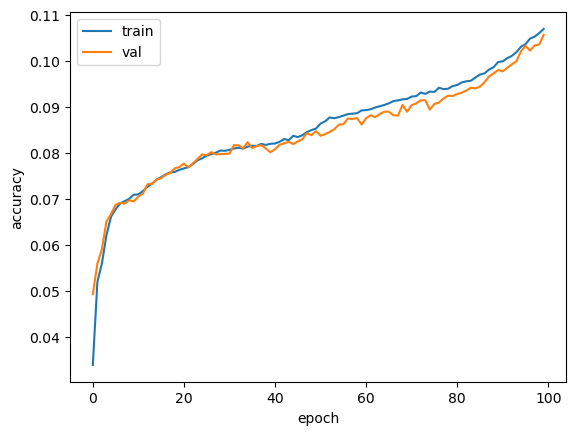

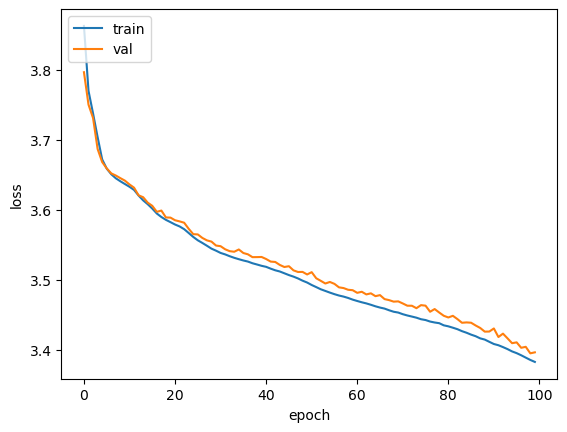

In [20]:
#@title Visualize training and validation GRU model
visualize_history(history_gru)

In [21]:
#@title Check random samples GRU model
check_samples(trained_model_gru, X_test, y_test, word_array, num_samples=10)

Input: train park park guitar Tokyo sunflower tulip apple desert guitar rose cucumber elephant sunflower desert car tulip bus 
Expected: bus tulip car desert sunflower elephant cucumber rose guitar desert apple tulip sunflower Tokyo guitar park park train 
Predicted: train train train guitar guitar guitar guitar park apple apple apple cherry Tokyo Tokyo blue park park park 
False

Input: broccoli strawberry park chair piano Tokyo motorcycle tomato green Paris strawberry purple island trumpet carrot bus yellow yellow 
Expected: yellow yellow bus carrot trumpet island purple strawberry Paris green tomato motorcycle Tokyo piano chair park strawberry broccoli 
Predicted: train train train tomato tomato guitar guitar guitar Tokyo Tokyo tomato tomato tomato tomato park park park park 
False

Input: banana flute lily mountain bus book trumpet piano elephant blue lion Paris apple lily beach desert strawberry bicycle 
Expected: bicycle strawberry desert beach lily apple Paris lion blue elephant

#2.3. Long Short-Term Memory model (LSTM)

In this section we are going to talk about Long-Short Term Memory (LSTM) networks, which are a special kind of recurrent neural network. Unlike Gated Recurrent Units (GRUs), LSTMs have a more complex structure with three key components that help them remember and understand sequences better. These components are the input gate, the forget gate, and the output gate. They're really good at capturing long-term patterns in data, which is super useful for tasks involving sequences. LSTMs are especially great for dealing with complex sequences, and they can hold on to important information for longer, so nothing important gets forgotten. These unique features make LSTMs an essential tool for handling challenging tasks involving time series data and sequences in the world of deep learning.



In [22]:
#@title Create LSTM model
numberOfUnits = 16
model_LSTM = Sequential(name='model_LSTM')
model_LSTM.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()
plot_model(model_LSTM,show_shapes=True)

Model: "model_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18, 16)         │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 18, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 18, 50)         │           850 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,250 (28.32 KB)

 Trainable params: 7,250 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
#@title Train and Evaluate LSTM model
trained_model_lstm, history_lstm = train_test(model_LSTM, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 8s - 14ms/step - accuracy: 0.0423 - loss: 3.8216 - val_accuracy: 0.0554 - val_loss: 3.7533
Epoch 2/100
563/563 - 4s - 8ms/step - accuracy: 0.0621 - loss: 3.7047 - val_accuracy: 0.0659 - val_loss: 3.6765
Epoch 3/100
563/563 - 4s - 7ms/step - accuracy: 0.0686 - loss: 3.6591 - val_accuracy: 0.0718 - val_loss: 3.6434
Epoch 4/100
563/563 - 4s - 8ms/step - accuracy: 0.0735 - loss: 3.6213 - val_accuracy: 0.0766 - val_loss: 3.6093
Epoch 5/100
563/563 - 4s - 8ms/step - accuracy: 0.0771 - loss: 3.5951 - val_accuracy: 0.0782 - val_loss: 3.5922
Epoch 6/100
563/563 - 4s - 7ms/step - accuracy: 0.0786 - loss: 3.5811 - val_accuracy: 0.0785 - val_loss: 3.5841
Epoch 7/100
563/563 - 4s - 8ms/step - accuracy: 0.0798 - loss: 3.5675 - val_accuracy: 0.0799 - val_loss: 3.5663
Epoch 8/100
563/563 - 4s - 7ms/step - accuracy: 0.0818 - loss: 3.5533 - val_accuracy: 0.0817 - val_loss

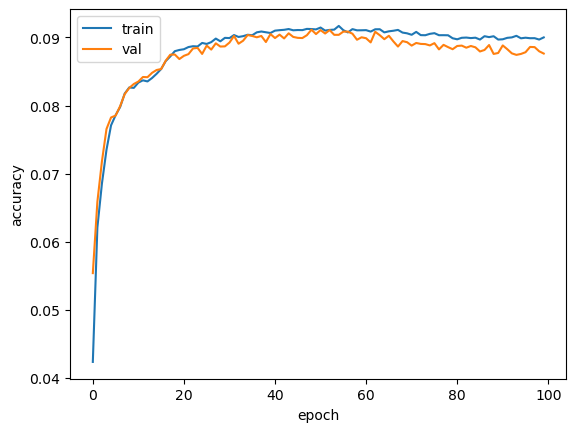

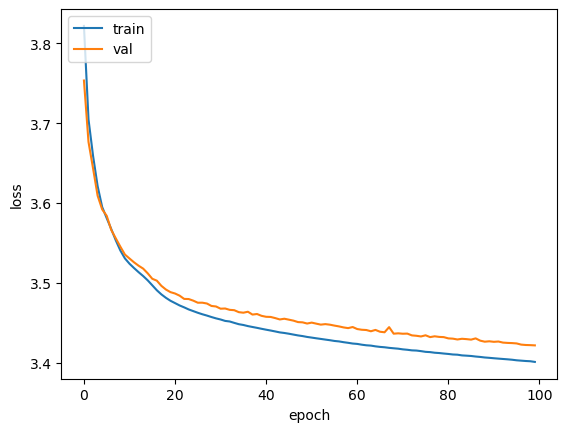

In [24]:
#@title Visualize training and validation LSTM model
visualize_history(history_lstm)

In [25]:
#@title Check random samples LSTM model
check_samples(trained_model_lstm, X_test, y_test, word_array, num_samples=10)

Input: Tokyo London mountain carrot banana bicycle chair cucumber computer bird mountain book lily sunflower flute book potato cat 
Expected: cat potato book flute sunflower lily book mountain bird computer cucumber chair bicycle banana carrot mountain London Tokyo 
Predicted: Tokyo London London London London carrot carrot red red Tokyo Tokyo bicycle carrot carrot carrot carrot carrot chair 
False

Input: potato desert guitar lamp Paris book beach cucumber trumpet cherry computer motorcycle car tulip violin rose car cherry 
Expected: cherry car rose violin tulip car motorcycle computer cherry trumpet cucumber beach book Paris lamp guitar desert potato 
Predicted: potato potato table potato potato elephant elephant carrot carrot Paris Paris Paris Paris Paris Paris Paris Paris Paris 
False

Input: lily desert cat red Paris mountain park sunflower Colombo tomato bicycle purple book Sydney mountain elephant apple lion 
Expected: lion apple elephant mountain Sydney book purple bicycle toma

#3. Information Sharing between RNN Layers
Up until now, we've been using a single method: passing all the hidden states from one RNN layer to the next. But now, we're about to learn three more methods for sharing information. These methods work for all RNNs, not just LSTMs. These additional methods include:
1. Sharing only the last hidden state, which represents a part of the information from the current and recent time steps, with the next layer.
2. Sharing both the last hidden state and the last cell state, where the cell state serves as another part of the information and specializes in preserving long-term memory and dependencies.
3. Sharing all the hidden states (representing the previous states in the sequence) and the last cell state.

In this context, it's important to note that while the hidden states capture short-term memory and patterns, the cell state, an integral component, is responsible for managing long-term memory and preserving extended dependencies in the data.

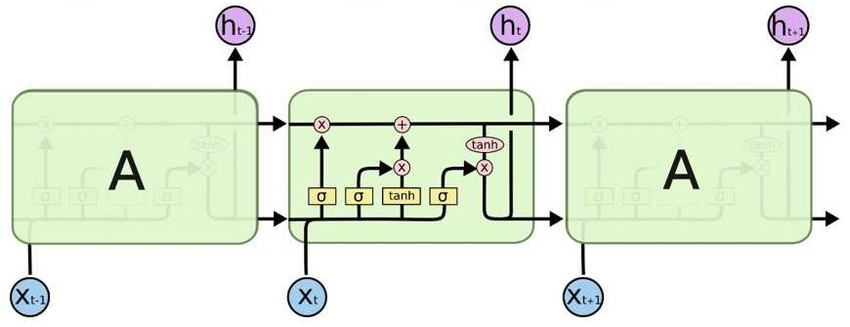

#3.1. LSTM model - Only last hidden state



In [26]:
#@title Create LSTM model with only last hidden state
numberOfUnits = 16
model_LSTM_with_last_hidden = Sequential(name='model_LSTM_with_last_hidden')
model_LSTM_with_last_hidden.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(Dense(n_features, activation='softmax'))


model_LSTM_with_last_hidden.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden.summary()
plot_model(model_LSTM_with_last_hidden,show_shapes=True)

Model: "model_LSTM_with_last_hidden"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 16)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 18, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 18, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 18, 50)         │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,250 (28.32 KB)

 Trainable params: 7,250 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [27]:
#@title Train and Evaluate LSTM model with only last hidden state
trained_model_with_last_hidden, history_with_last_hidden = train_test(model_LSTM_with_last_hidden, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 6s - 11ms/step - accuracy: 0.0459 - loss: 3.8156 - val_accuracy: 0.0584 - val_loss: 3.7512
Epoch 2/100
563/563 - 4s - 6ms/step - accuracy: 0.0686 - loss: 3.6924 - val_accuracy: 0.0762 - val_loss: 3.6443
Epoch 3/100
563/563 - 4s - 7ms/step - accuracy: 0.0824 - loss: 3.5999 - val_accuracy: 0.0875 - val_loss: 3.5721
Epoch 4/100
563/563 - 4s - 6ms/step - accuracy: 0.0872 - loss: 3.5603 - val_accuracy: 0.0901 - val_loss: 3.5566
Epoch 5/100
563/563 - 4s - 7ms/step - accuracy: 0.0898 - loss: 3.5410 - val_accuracy: 0.0917 - val_loss: 3.5344
Epoch 6/100
563/563 - 4s - 6ms/step - accuracy: 0.0914 - loss: 3.5247 - val_accuracy: 0.0923 - val_loss: 3.5267
Epoch 7/100
563/563 - 4s - 6ms/step - accuracy: 0.0917 - loss: 3.5181 - val_accuracy: 0.0919 - val_loss: 3.5226
Epoch 8/100
563/563 - 4s - 6ms/step - accuracy: 0.0921 - loss: 3.5138 - val_accuracy: 0.0917 - val_loss

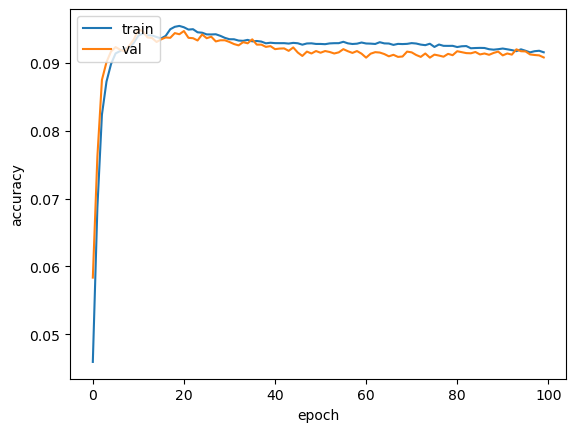

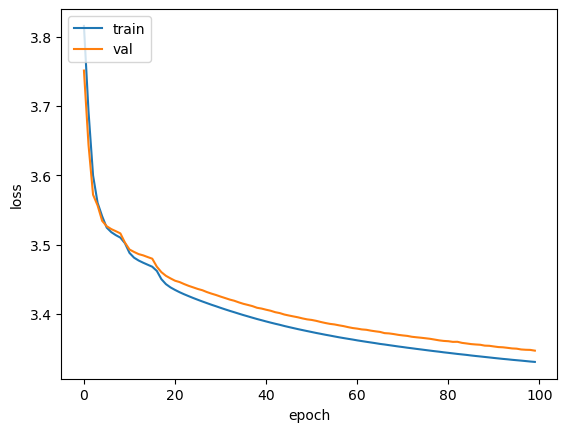

In [28]:
#@title Visualize training and validation LSTM model with only last hidden state
visualize_history(history_with_last_hidden)

In [29]:
#@title Check random samples LSTM model with only last hidden state
check_samples(trained_model_with_last_hidden, X_test, y_test, word_array, num_samples=10)

Input: lily trumpet blue carrot cucumber London potato violin lamp dog desert strawberry train table carrot book purple Colombo 
Expected: Colombo purple book carrot table train strawberry desert dog lamp violin potato London cucumber carrot blue trumpet lily 
Predicted: carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot carrot 
False

Input: lamp train blue mountain train lily park Paris Tokyo daisy broccoli park rose rose cherry piano sunflower cherry 
Expected: cherry sunflower piano cherry rose rose park broccoli daisy Tokyo Paris park lily train mountain blue train lamp 
Predicted: train train train train train train train train train train train train train train train train train train 
False

Input: guitar motorcycle motorcycle London broccoli tulip bird park sunflower motorcycle bird broccoli table flute elephant mountain island chair 
Expected: chair island mountain elephant flute table broccoli bird motorcyc

#3.2. LSTM model - Last hidden state and last cell state

In [30]:
#@title Create LSTM model with last hidden state and last cell state
numberOfUnits = 16
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_state=True)
LSTM_output, state_h, state_c = lstm1(input)
states = [state_h, state_c]

repeat=RepeatVector(n_timesteps_in)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_last_hidden_and_last_cell = Model(input,output,name='model_LSTM_with_last_hidden_and_last_cell')
model_LSTM_with_last_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_last_hidden_and_last_cell,show_shapes=True)

Model: "model_LSTM_with_last_hidden_and_last_cell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 18, 50)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 16),      │      4,288 │ input_layer_5[0]… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 18, 16)    │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 18, 16)    │      2,112 │ repeat_vector_2[… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 18, 50)    │        850 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,250 (28.32 KB)

 Trainable params: 7,250 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [31]:
#@title Train and Evaluate LSTM model with last hidden state and last cell state
trained_model_with_last_hidden_and_last_cell, history_with_last_hidden_and_last_cell = train_test(model_LSTM_with_last_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 7s - 13ms/step - accuracy: 0.0461 - loss: 3.8154 - val_accuracy: 0.0625 - val_loss: 3.7345
Epoch 2/100
563/563 - 4s - 7ms/step - accuracy: 0.0726 - loss: 3.6792 - val_accuracy: 0.0816 - val_loss: 3.6354
Epoch 3/100
563/563 - 4s - 7ms/step - accuracy: 0.0870 - loss: 3.5886 - val_accuracy: 0.0939 - val_loss: 3.5540
Epoch 4/100
563/563 - 4s - 8ms/step - accuracy: 0.0963 - loss: 3.5264 - val_accuracy: 0.1018 - val_loss: 3.5123
Epoch 5/100
563/563 - 4s - 7ms/step - accuracy: 0.1014 - loss: 3.4939 - val_accuracy: 0.1048 - val_loss: 3.4912
Epoch 6/100
563/563 - 4s - 7ms/step - accuracy: 0.1034 - loss: 3.4767 - val_accuracy: 0.1060 - val_loss: 3.4797
Epoch 7/100
563/563 - 4s - 8ms/step - accuracy: 0.1050 - loss: 3.4666 - val_accuracy: 0.1059 - val_loss: 3.4742
Epoch 8/100
563/563 - 4s - 8ms/step - accuracy: 0.1061 - loss: 3.4593 - val_accuracy: 0.1070 - val_loss

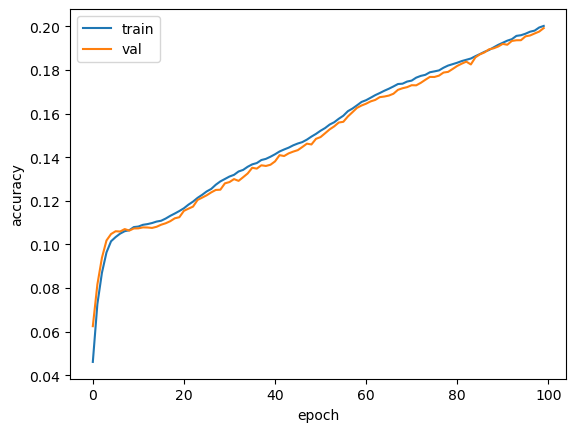

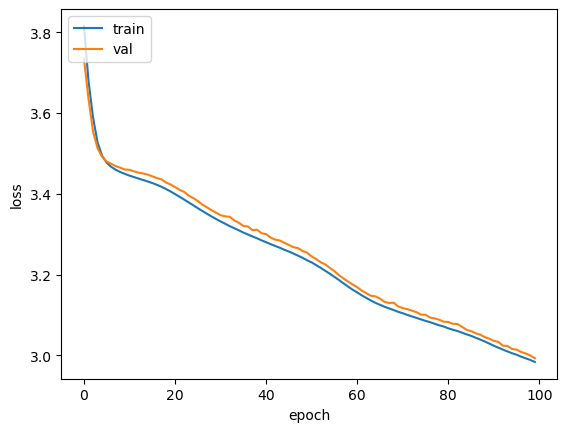

In [32]:
#@title Visualize training and validation LSTM model with last hidden state and last cell state
visualize_history(history_with_last_hidden_and_last_cell)

In [33]:
#@title Check random samples LSTM model with last hidden state and last cell state
check_samples(trained_model_with_last_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: violin banana bus Paris dog dog apple orange cherry broccoli lily sunflower red rose beach piano daisy orange 
Expected: orange daisy piano beach rose red sunflower lily broccoli cherry orange apple dog dog Paris bus banana violin 
Predicted: orange purple piano London table table table lily violin violin violin violin violin violin violin bus bus bus 
False

Input: flute book banana green car blue Sydney violin car motorcycle tulip Colombo piano violin chair island tulip dog 
Expected: dog tulip island chair violin piano Colombo tulip motorcycle car violin Sydney blue car green banana book flute 
Predicted: dog bus island piano tulip piano piano violin violin violin green green green green green green orange red 
False

Input: chair elephant bicycle bird train Colombo dog potato lion elephant Paris lamp Paris Tokyo red cat red island 
Expected: island red cat red Tokyo Paris lamp Paris elephant lion potato dog Colombo train bird bicycle elephant chair 
Predicted: trumpet red re

#3.3. LSTM model - All hidden states and last cell state

In [34]:
#@title Create LSTM model with all hidden states and last cell state
numberOfUnits = 16
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input)
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_all_hidden_and_last_cell = Model(input,output, name='model_LSTM_with_all_hidden_and_last_cell')
model_LSTM_with_all_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_all_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_all_hidden_and_last_cell,show_shapes=True)

Model: "model_LSTM_with_all_hidden_and_last_cell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 18, 50)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 18, 16),  │      4,288 │ input_layer_6[0]… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 18, 16)    │      2,112 │ lstm_6[0][0],     │
│                     │                   │            │ lstm_6[0][1],     │
│                     │                   │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 18, 50)    │        850 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,250 (28.32 KB)

 Trainable params: 7,250 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [35]:
#@title Train and Evaluate LSTM model with all hidden states and last cell state
trained_model_with_all_hidden_and_last_cell, history_with_all_hidden_and_last_cell = train_test(model_LSTM_with_all_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 8s - 14ms/step - accuracy: 0.0533 - loss: 3.7937 - val_accuracy: 0.0752 - val_loss: 3.6907
Epoch 2/100
563/563 - 4s - 8ms/step - accuracy: 0.0811 - loss: 3.6390 - val_accuracy: 0.0905 - val_loss: 3.5911
Epoch 3/100
563/563 - 4s - 8ms/step - accuracy: 0.0949 - loss: 3.5561 - val_accuracy: 0.1011 - val_loss: 3.5250
Epoch 4/100
563/563 - 4s - 8ms/step - accuracy: 0.1041 - loss: 3.5021 - val_accuracy: 0.1076 - val_loss: 3.4776
Epoch 5/100
563/563 - 4s - 8ms/step - accuracy: 0.1117 - loss: 3.4575 - val_accuracy: 0.1145 - val_loss: 3.4373
Epoch 6/100
563/563 - 4s - 8ms/step - accuracy: 0.1178 - loss: 3.4209 - val_accuracy: 0.1199 - val_loss: 3.4029
Epoch 7/100
563/563 - 4s - 7ms/step - accuracy: 0.1238 - loss: 3.3872 - val_accuracy: 0.1261 - val_loss: 3.3706
Epoch 8/100
563/563 - 4s - 8ms/step - accuracy: 0.1305 - loss: 3.3503 - val_accuracy: 0.1336 - val_loss

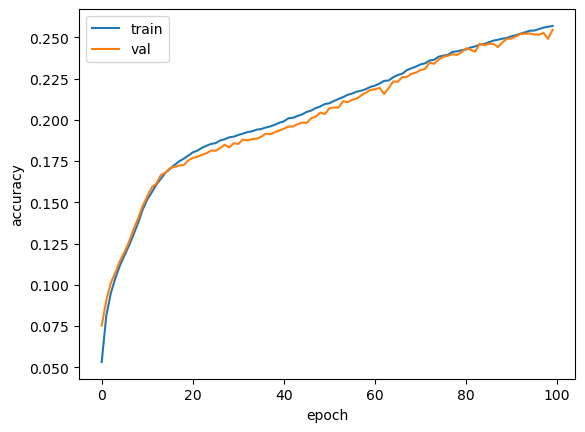

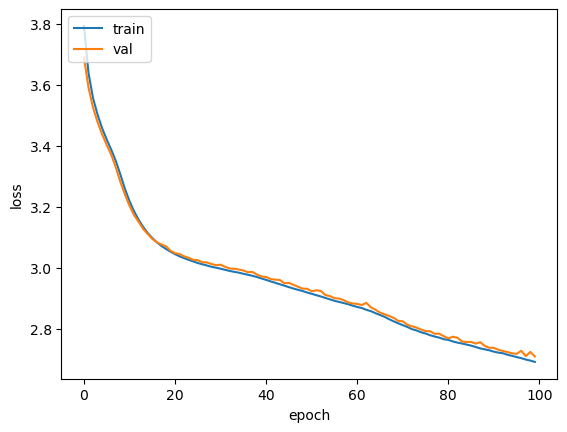

In [36]:
#@title Visualize training and validation LSTM model with all hidden states and last cell state
visualize_history(history_with_all_hidden_and_last_cell)

In [37]:
#@title Check random samples LSTM model with all hidden states and last cell state
check_samples(trained_model_with_all_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: trumpet desert rose broccoli blue bus London tomato table elephant motorcycle mountain elephant train bird rose dog Paris 
Expected: Paris dog rose bird train elephant mountain motorcycle elephant table tomato London bus blue broccoli rose desert trumpet 
Predicted: Paris carrot carrot bird train train bus green broccoli mountain broccoli London broccoli broccoli London London rose trumpet 
False

Input: table rose flute potato blue bicycle sunflower orange computer computer chair guitar Colombo mountain apple orange cherry red 
Expected: red cherry orange apple mountain Colombo guitar chair computer computer orange sunflower bicycle blue potato flute rose table 
Predicted: park park bicycle apple mountain dog trumpet train elephant rose beach trumpet book Paris lily lily orange table 
False

Input: piano bus lion rose cucumber tomato strawberry train chair motorcycle lamp orange strawberry table bicycle carrot orange cherry 
Expected: cherry orange carrot bicycle table strawber

#Reference
1. https://www.muratkarakaya.net/2022/11/seq2seq-learning-tutorial-series.html
2. https://deeplearningmath.org/sequence-models.html
